Some notes. 

There are some artifacts in the "original" images for oversampling PSF, stamp scale 2. These seem to largely go away if we instead use an interpolated image of the oversampled psf to convolve with the galaxies, draw them, use the resulting stamp size, and draw the galaxies again with the *original* psf, not the interpolated image. The artifacts are instead significantly worsened if the interpolated image is used both times. 

In [1]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
from scipy.optimize import curve_fit
import time
from galsim.gsparams import GSParams
from galsim.hsm import HSMParams
from scipy import fftpack
import shape_measurement as sm

In [3]:
#Simulation options
shearList = [(0,0)] #list of shears to apply
gsparams = galsim.GSParams(maximum_fft_size=12288)

#Parameters of the PSF
psf_sigma = 0.5 #as
pixel_scale = 0.1 #as/px

#Airy PSF
lamda = 550 #nm
diameter = 1.2 #m
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3, gsparams=gsparams)
pixel = galsim.Pixel(pixel_scale,gsparams=gsparams)
psf = galsim.Convolve(airy, pixel,real_space=False)

psfii_size = 2048
image_psf=psf.drawImage(scale=pixel_scale,method='no_pixel')

oversampled_image_psf=galsim.ImageF(psfii_size,psfii_size)
oversampled_image_psf=psf.drawImage(image=oversampled_image_psf, scale=pixel_scale/10.,method='no_pixel')
psfii = galsim.InterpolatedImage(oversampled_image_psf, gsparams=gsparams)

In [73]:
def makeGaussian(im, flux=1., gsparams=None):
    im_mom = galsim.hsm.FindAdaptiveMom(im,strict=False)
    if im_mom.moments_status != 0:
        #print im_mom.correction_status
        return False, False, False
    else:
        im_mom_sigma, im_mom_shear = im_mom.moments_sigma, im_mom.observed_shape
        im_gaussian = galsim.Gaussian(sigma=im_mom_sigma, flux=flux, gsparams=gsparams)
        im_gaussian = im_gaussian.shear(g1=im_mom_shear.g1,g2=im_mom_shear.g2)
        return im_gaussian, im_mom_sigma, im_mom_shear

In [86]:
psf_gaussian = makeGaussian(oversampled_image_psf,gsparams=gsparams)[0]
given_psf = psf_gaussian.drawImage(scale=pixel_scale/10.,method='no_pixel')
gauss_psfii = galsim.InterpolatedImage(given_psf, gsparams=gsparams)

MemoryError: 

In [75]:
#Load galaxy catalog and select galaxies
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)
hlr, sn, q = [np.array([pc[4][i] for pc in cc.param_cat]) for i in range(1,4)]

small100I = np.where(np.logical_and(hlr*np.sqrt(q)>2.5, sn>=0.3))[0][:100] #Large galaxies
galaxies = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)


In [76]:
galaxies_gauss, galaxies_sigma, galaxies_shear = [],[],[]
for gal in galaxies:
    oversampled_im_gal = gal.drawImage(scale=pixel_scale/10., method='no_pixel')
    gal_gaussian, sig, shear = makeGaussian(oversampled_im_gal, flux=gal.flux, gsparams=gsparams)
    galaxies_gauss.append(gal_gaussian); galaxies_sigma.append(sig); galaxies_shear.append(shear)
galaxies_gauss = np.array(galaxies_gauss)
failed = galaxies_gauss==False

In [85]:
for gal in galaxies_gauss[~failed]:
    psfgal = galsim.Convolution([gal, psf_gaussian])

In [5]:
#Draw galaxy images
ts = time.clock()
galIms=[]
#imm = galsim.ImageF(64,64)
for gal in galaxies:
    psfgal = galsim.Convolution([gal, psfii],real_space=False)
    galIm = psfgal.drawImage(scale=pixel_scale, method='no_pixel')
    galIms.append(galIm)
print time.clock() - ts

2.336757


(96, 96)


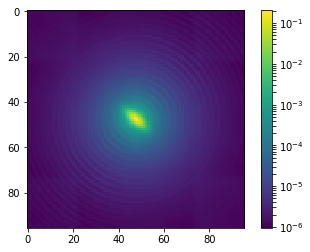

In [6]:
from matplotlib.colors import LogNorm
plt.imshow(galIms[0].array,norm=LogNorm());plt.colorbar()
#plt.xlim(30,60);plt.ylim(30,60)
print galIms[0].array.shape

In [7]:
def roundup2(a):
    return int(2**np.ceil(np.log2(a)))

In [8]:
stamp_scale = 1
base_images=[galsim.ImageF(roundup2(gal.array.shape[0]*stamp_scale),roundup2(gal.array.shape[1]*stamp_scale),scale=pixel_scale) for gal in galIms]
base_images2=[galsim.ImageF(roundup2(gal.array.shape[0]*stamp_scale),roundup2(gal.array.shape[1]*stamp_scale),scale=pixel_scale) for gal in galIms]

In [9]:
ts = time.clock()
galIms=[]
for i,gal in enumerate(galaxies):
    psfgal = galsim.Convolution([gal, psfii],real_space=False)
    galIm = psfgal.drawImage(image=base_images[i],scale=pixel_scale, method='no_pixel')
    galIms.append(galIm)
print time.clock() - ts

1.858711


In [10]:
shearedIm=[]
for i,gal in enumerate(galIms):
    gali = galsim.InterpolatedImage(gal,gsparams=gsparams) #Warning: these are large and take a lot of memory
    shRow = sm.cfGal(gali,psfii,shearList) # Warning: these are large and take a lot of memory
    shearedImRow = [sh.drawImage(image=base_images2[i],method='no_pixel',scale=pixel_scale) for sh in shRow]
    shearedIm.append(shearedImRow)
shearedIm=np.array(shearedIm)

In [11]:
psf_sigma=1
obsOrig = np.array([sm.measureObsShape(gal,image_psf, hlr[i]*pixel_scale, psf_sigma, pixel_scale) for i,gal in enumerate(galIms)])
obsConv = np.array([sm.measureObsShape(gal,image_psf, hlr[i]*pixel_scale, psf_sigma, pixel_scale) for i,gal in enumerate(shearedIm.transpose()[0])])

e1,e2 = obsOrig.transpose()[0],obsOrig.transpose()[1]
e1c,e2c = obsConv.transpose()[0],obsConv.transpose()[1]

In [13]:
ooT = obsOrig.transpose()
ocT = obsConv.transpose()
diffI = np.where(ooT[-1] != ocT[-1])[0]
sameI = np.where(np.logical_and(ooT[-1] == 0, ocT[-1] == 0.))[0]
for i in diffI:
    print ooT[-1,i], ocT[-1,i]
print 'number of failures original/conv: ', np.sum(ooT[-1] != 0),',', np.sum(ocT[-1] != 0)

0.0 -9.0
number of failures original/conv:  4 , 5


In [14]:
for i in diffI:
    print (ooT[-1,i] - ocT[-1,i])/9.
diffErr = np.array([(ooT[-1,i] - ocT[-1,i])/9. for i in diffI])
print diffErr
origErr = np.abs(np.sum(diffErr[diffErr<0]))
convError = np.abs(np.sum(diffErr[diffErr>0]))

1.0
[1.]


In [15]:
diffe1 = e1-e1c
diffe2 = e2-e2c
diffe1 = diffe1[sameI]
diffe2 = diffe2[sameI]
print min(diffe1),max(diffe1)
print min(diffe2),max(diffe2)



-0.01828819513320934 0.0122128427028656
-0.020231306552886963 0.011087298393249623


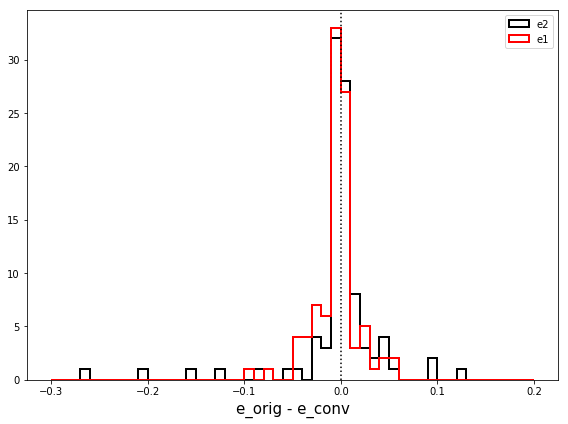

In [60]:
fig,ax=plt.subplots(sharey=True,figsize=(8,6))

b=ax.hist(diffe2,histtype='step',range=(-0.3,0.2),bins=50,linewidth=2,color='k',label='e2')
a=ax.hist(diffe1,histtype='step',range=(-0.3,0.2),bins=50,linewidth=2,color='r',label='e1')
#b=ax.hist(diffe2,histtype='step',range=(-0.06,0.05),bins=88,linewidth=2,color='k',label='e2')
#a=ax.hist(diffe1,histtype='step',range=(-0.06,0.05),bins=88,linewidth=2,color='r',label='e1')
ax.legend()
plt.subplots_adjust(wspace=0)
ax.set_xlabel('e_orig - e_conv',size=15)
plt.axvline(0,color='k',linestyle=':')
#ax.set_xlim(-0.4,0.3)
plt.tight_layout()
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/e_diff_histogram_quadruplestamp_oversamplepsf.png')

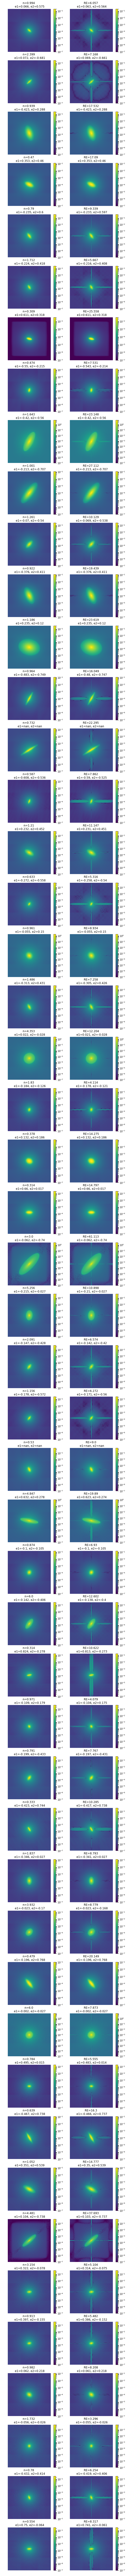

In [16]:
shearedFlat = shearedIm.flatten()

from matplotlib.colors import LogNorm
x=50
zoom = False
vlim = False

if vlim:
    vmax = 0.1
else:
    vmax=None
vmin=1e-7
fig,ax=plt.subplots(x,2,figsize=(9,200),sharey=False,sharex=False)
for i in range(x):
    subax0,subax1= ax[i,0], ax[i,1]
    vmax=np.amax(galIms[i].array)
    im0=subax0.imshow(np.abs(galIms[i].array),interpolation='none',vmin=vmin,vmax=vmax,norm=LogNorm())
    im1=subax1.imshow(np.abs(shearedFlat[i].array), interpolation='none', vmin=vmin,vmax=vmax,norm=LogNorm())
    #_im2 = subax2.imshow(np.abs(shearedFlatNoE[i].array), interpolation='none', vmax=vmax,norm=norm)
    subax0.axes.axis('off');subax1.axes.axis('off')#;subax2.axes.axis('off')
    title2 = "RE={0} \n e1={1}, e2={2}".format(np.round(hlr[small100I[i]],3), np.round(e1c[i],3), np.round(e2c[i],3))
    title = "n={0} \n e1={1}, e2={2}".format(np.round(sn[small100I][i],3),np.round(e1[i],3), np.round(e2[i],3))    
    subax0.set_title(title)
    subax1.set_title(title2)
    #subax2.set_title(np.round(sn[small100I][i],3))
    fig.colorbar(im0,ax=subax0)
    fig.colorbar(im1,ax=subax1)
    
#ax[0,0].set_title('Original')
#ax[0,1].set_title('Reconvolved')
#ax[0,2].set_title('Reconvolved_noDil')
plt.subplots_adjust(hspace=0.2,wspace=0.1)
#plt.savefig('/home/rosenberg/Documents/wl-bias-leaps-top/shear_bias_outputs/convolutionEffects_oversamplepsf_doublestamp_psfiiboth.png')
